
# FNOを用いた2次元Darcy-Flowの学習

#### 必要なパッケージのインポート

In [1]:
import torch
import matplotlib.pyplot as plt
import sys
import datetime
import os
from io import StringIO

from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

import logging
from pathlib import Path
from typing import Union, List

from torch.utils.data import DataLoader

from neuralop.data.datasets.pt_dataset import PTDataset
from neuralop.data.datasets.web_utils import download_from_zenodo_record

from neuralop.utils import get_project_root

In [2]:
import wandb

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="neuralop_test",
)

wandb: Currently logged in as: t-shimizu (t-shimizu-kobe-university). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


#### コード内で使用するパラメータまとめ

##### データの読み込み関係

In [3]:
device = 'cpu'
N_train = 100
batch_size = 32
train_resolution = 32
test_resolutions = [16, 32, 64]
N_tests = [50, 50, 50]
test_batch_sizes = [32, 32, 32]

download=True

##### FNOモデル関係

In [4]:
N_modes = (32, 32)
in_channels = 1
out_channels = 1
hidden_channels = 32
projection_channel_ratio = 2

##### optimizer関係

In [5]:
lerning_rate = 8e-3
weight_decay = 1e-4
T_max = 30

##### トレーナー関係

In [6]:
N_epochs = 20
wandb_log = True
log_output = True
eval_interval = 1
use_distributed = False
verbose = True
regularizer = False

##### ファイル出力関係

In [7]:
dt_now = datetime.datetime.now()
output_dir = "../results/FNO/" + dt_now.strftime("%Y-%m-%d_%H:%M:%S") + "/"

os.makedirs(output_dir, exist_ok=True)

# 標準出力をキャプチャする関数
def capture_output(func, *args, **kwargs):
    # 元の標準出力を保存
    original_stdout = sys.stdout
    sys.stdout = StringIO()  # 標準出力をStringIOに切り替え

    try:
        func(*args, **kwargs)  # 渡された関数を実行
        output = sys.stdout.getvalue()  # キャプチャされた出力を取得
    finally:
        sys.stdout = original_stdout  # 標準出力を元に戻す

    return output

#### 使用するデータの読み込み（load_darcy_flow_smallを参考に、load_darcy_flow関数に変更して使用できる解像度の幅を増やした）

In [8]:
class DarcyDataset(PTDataset):
    """
    DarcyDataset stores data generated according to Darcy's Law.
    Input is a coefficient function and outputs describe flow. 

    Data source: https://zenodo.org/records/12784353

    Attributes
    ----------
    train_db: torch.utils.data.Dataset of training examples
    test_db:  ""                       of test examples
    data_processor: neuralop.data.transforms.DataProcessor to process data examples
        optional, default is None
    """
    def __init__(self,
                 root_dir: Union[Path, str],
                 n_train: int,
                 n_tests: List[int],
                 batch_size: int,
                 test_batch_sizes: List[int],
                 train_resolution: int,
                 test_resolutions: List[int],
                 encode_input: bool=False, 
                 encode_output: bool=True, 
                 encoding="channel-wise",
                 channel_dim=1,
                 subsampling_rate=None,
                 download: bool=True):

        """DarcyDataset

        Parameters
        ----------
        root_dir : Union[Path, str]
            root at which to download data files
        dataset_name : str
            prefix of pt data files to store/access
        n_train : int
            number of train instances
        n_tests : List[int]
            number of test instances per test dataset
        batch_size : int
            batch size of training set
        test_batch_sizes : List[int]
            batch size of test sets
        train_resolution : int
            resolution of data for training set
        test_resolutions : List[int], optional
            resolution of data for testing sets, by default [16,32]
        encode_input : bool, optional
            whether to normalize inputs in provided DataProcessor,
            by default False
        encode_output : bool, optional
            whether to normalize outputs in provided DataProcessor,
            by default True
        encoding : str, optional
            parameter for input/output normalization. Whether
            to normalize by channel ("channel-wise") or 
            by pixel ("pixel-wise"), default "channel-wise"
        input_subsampling_rate : int or List[int], optional
            rate at which to subsample each input dimension, by default None
        output_subsampling_rate : int or List[int], optional
            rate at which to subsample each output dimension, by default None
        channel_dim : int, optional
            dimension of saved tensors to index data channels, by default 1
        """

        # convert root dir to Path
        if isinstance(root_dir, str):
            root_dir = Path(root_dir)
        if not root_dir.exists():
            root_dir.mkdir(parents=True)

        # Zenodo record ID for Darcy-Flow dataset
        zenodo_record_id = "12784353"

        # List of resolutions needed for dataset object
        resolutions = set(test_resolutions + [train_resolution])

        # We store data at these resolutions on the Zenodo archive
        available_resolutions = [16, 32, 64, 128, 421]
        for res in resolutions:
            assert res in available_resolutions, f"Error: resolution {res} not available"

        # download darcy data from zenodo archive if passed
        if download:
            files_to_download = []
            already_downloaded_files = [x for x in root_dir.iterdir()]
            for res in resolutions:
                if f"darcy_train_{res}.pt" not in already_downloaded_files or \
                f"darcy_test_{res}.pt" not in already_downloaded_files:    
                    files_to_download.append(f"darcy_{res}.tgz")
            download_from_zenodo_record(record_id=zenodo_record_id,
                                        root=root_dir,
                                        files_to_download=files_to_download)
            
        # once downloaded/if files already exist, init PTDataset
        super().__init__(root_dir=root_dir,
                       dataset_name="darcy",
                       n_train=n_train,
                       n_tests=n_tests,
                       batch_size=batch_size,
                       test_batch_sizes=test_batch_sizes,
                       train_resolution=train_resolution,
                       test_resolutions=test_resolutions,
                       encode_input=encode_input,
                       encode_output=encode_output,
                       encoding=encoding,
                       channel_dim=channel_dim,
                       input_subsampling_rate=subsampling_rate,
                       output_subsampling_rate=subsampling_rate)
        
# legacy Small Darcy Flow example
example_data_root = get_project_root() / "neuralop/data/datasets/data"

def load_darcy_flow(n_train,
    n_tests,
    batch_size,
    test_batch_sizes,
    data_root = example_data_root,
    test_resolutions=test_resolutions,
    encode_input=False,
    encode_output=True,
    encoding="channel-wise",
    channel_dim=1,):

    dataset = DarcyDataset(root_dir = data_root,
                           n_train=n_train,
                           n_tests=n_tests,
                           batch_size=batch_size,
                           test_batch_sizes=test_batch_sizes,
                           train_resolution=train_resolution,
                           test_resolutions=test_resolutions,
                           encode_input=encode_input,
                           encode_output=encode_output,
                           channel_dim=channel_dim,
                           encoding=encoding,
                           download=True)
    
    # return dataloaders for backwards compat
    train_loader = DataLoader(dataset.train_db,
                              batch_size=batch_size,
                              num_workers=0,
                              pin_memory=True,
                              persistent_workers=False,)
    
    test_loaders = {}
    for res,test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(dataset.test_dbs[res],
                                       batch_size=test_bsize,
                                       shuffle=False,
                                       num_workers=0,
                                       pin_memory=True,
                                       persistent_workers=False,)
    
    return train_loader, test_loaders, dataset.data_processor

In [9]:
train_loader, test_loaders, data_processor = load_darcy_flow(
        n_train=N_train, batch_size=batch_size, 
        test_resolutions=test_resolutions, n_tests=N_tests,
        test_batch_sizes=test_batch_sizes,
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 50 samples 
Loading test db for resolution 32 with 50 samples 
Loading test db for resolution 64 with 50 samples 


/home/shimi3435/workspace/python/neuralop_test_semi/neuraloperator/neuralop/data/datasets/pt_dataset.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(


#### FNOモデルの作成

In [10]:
model = FNO(n_modes=N_modes,
             in_channels=in_channels, 
             out_channels=out_channels,
             hidden_channels=hidden_channels, 
             projection_channel_ratio=projection_channel_ratio)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 4469601 parameters.


#### optimizerの作成



In [11]:
optimizer = AdamW(model.parameters(), lr=lerning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

#### 使用するロスの設定

In [12]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

#### モデル、optimizer、scheduler、ロスのログ出力

In [13]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 32, 17]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64,

#### トレーナーの作成


In [14]:
trainer = Trainer(model=model, n_epochs=N_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=wandb_log,
                  log_output=log_output,
                  eval_interval=eval_interval,
                  use_distributed=use_distributed,
                  verbose=verbose)

#### 学習


In [15]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=regularizer, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 100 samples
Testing on [50, 50, 50] samples         on resolutions [16, 32, 64].
Raw outputs of shape torch.Size([32, 1, 32, 32])
[0] time=0.89, avg_loss=0.9885, train_err=24.7113
Eval: 16_h1=0.9107, 16_l2=0.5701, 32_h1=0.9754, 32_l2=0.5608, 64_h1=1.1078, 64_l2=0.5587
[1] time=0.62, avg_loss=0.9452, train_err=23.6298
Eval: 16_h1=0.8660, 16_l2=0.5859, 32_h1=0.8689, 32_l2=0.5797, 64_h1=0.8870, 64_l2=0.5797
[2] time=0.62, avg_loss=0.7757, train_err=19.3926
Eval: 16_h1=0.7868, 16_l2=0.7442, 32_h1=0.7546, 32_l2=0.7335, 64_h1=0.8386, 64_l2=0.7387
[3] time=0.67, avg_loss=0.6493, train_err=16.2325
Eval: 16_h1=0.7044, 16_l2=0.4585, 32_h1=0.6911, 32_l2=0.4434, 64_h1=0.7105, 64_l2=0.4405
[4] time=0.66, avg_loss=0.6470, train_err=16.1738
Eval: 16_h1=0.6579, 16_l2=0.4710, 32_h1=0.6727, 32_l2=0.4550, 64_h1=0.7773, 64_l2=0.4582
[5] time=0.66, avg_loss=0.5819, train_err=14.5482
Eval: 16_h1=0.5369, 16_l2=0.3377, 32_h1=0.5457, 32_l2=0.3274, 64_h1=0.6333, 64_l2=0.3306
[6] time=0.63, avg_loss=

{'train_err': 6.026699751615524,
 'avg_loss': 0.24106799006462099,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.6321148479910335,
 '16_h1': tensor(0.3612),
 '16_l2': tensor(0.2317),
 '16_outputs': <wandb.sdk.data_types.image.Image at 0x7f936c372ef0>,
 '32_h1': tensor(0.2873),
 '32_l2': tensor(0.1968),
 '32_outputs': <wandb.sdk.data_types.image.Image at 0x7f936c3b3850>,
 '64_h1': tensor(0.4589),
 '64_l2': tensor(0.2038),
 '64_outputs': <wandb.sdk.data_types.image.Image at 0x7f936c3b3700>}

In [16]:
#stdout = capture_output(lambda : trainer.train(train_loader=train_loader,
#              test_loaders=test_loaders,
#              optimizer=optimizer,
#              scheduler=scheduler, 
#              regularizer=regularizer, 
#              training_loss=train_loss,
#              eval_losses=eval_losses))
#
#print(stdout)

#with open(output_dir + 'stdout.txt', 'w') as f:
#    f.write(stdout)
#
#with open(output_dir + 'models.txt', 'w') as f:
#    f.write(f'\nOur model has {n_params} parameters.\n')
#    f.write('\n\n### MODEL ###\n')
#    f.write(str(model))
#    f.write('\n\n### OPTIMIZER ###\n')
#    f.write(str(optimizer))
#    f.write('\n\n### SCHEDULER ###\n')
#    f.write(str(scheduler))
#    f.write('\n\n### LOSSES ###')
#    f.write(f'\n\n * Train: {train_loss}')
#    f.write(f'\n\n * Test: {eval_losses}')
#    
#with open(output_dir + 'params.txt', 'w') as f:
#    f.write(f'N_train: {N_train}\n')
#    f.write(f'batch_size: {batch_size}\n')
#    f.write(f'test_resolutions: {test_resolutions}\n')
#    f.write(f'N_tests: {N_tests}\n')
#    f.write(f'test_batch_sizes: {test_batch_sizes}\n')
#    f.write(f'N_modes: {N_modes}\n')
#    f.write(f'in_channels: {in_channels}\n')
#    f.write(f'out_channels: {out_channels}\n')
#    f.write(f'hidden_channels: {hidden_channels}\n')
#    f.write(f'projection_channel_ratio: {projection_channel_ratio}\n')
#    f.write(f'lerning_rate: {lerning_rate}\n')
#    f.write(f'weight_decay: {weight_decay}\n')
#    f.write(f'T_max: {T_max}\n')
#    f.write(f'N_epochs: {N_epochs}\n')
#    f.write(f'wandb_log: {wandb_log}\n')
#    f.write(f'eval_interval: {eval_interval}\n')
#    f.write(f'use_distributed: {use_distributed}\n')
#    f.write(f'verbose: {verbose}\n')
#    f.write(f'regularizer: {regularizer}\n')

Visualizing predictions
------------------------
16×16

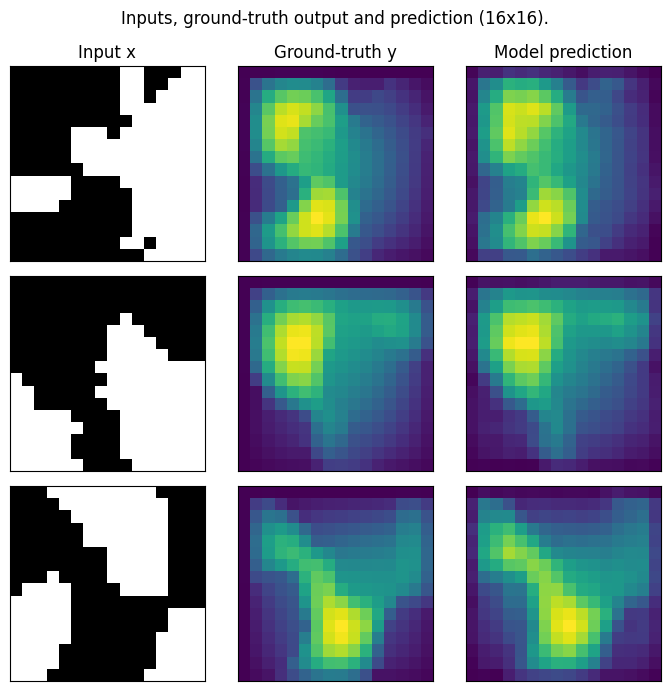

In [17]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
plt.show()

32×32

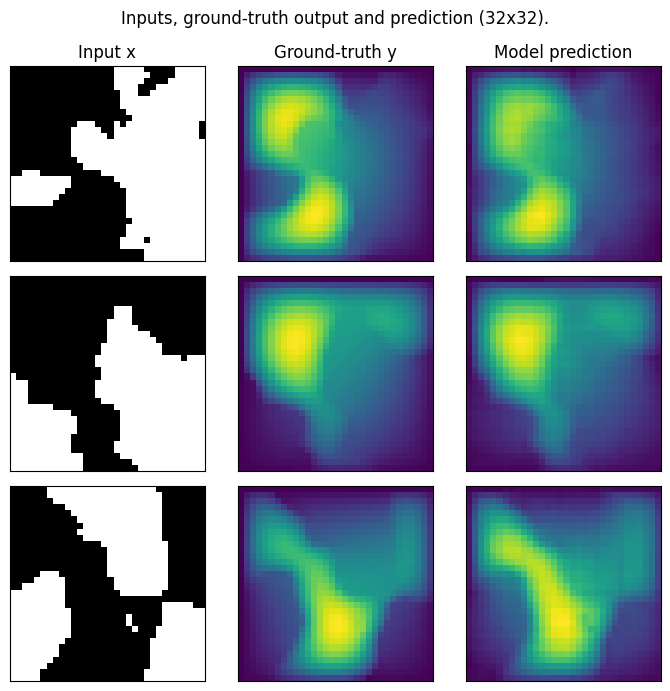

In [18]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()
plt.show()

64×64

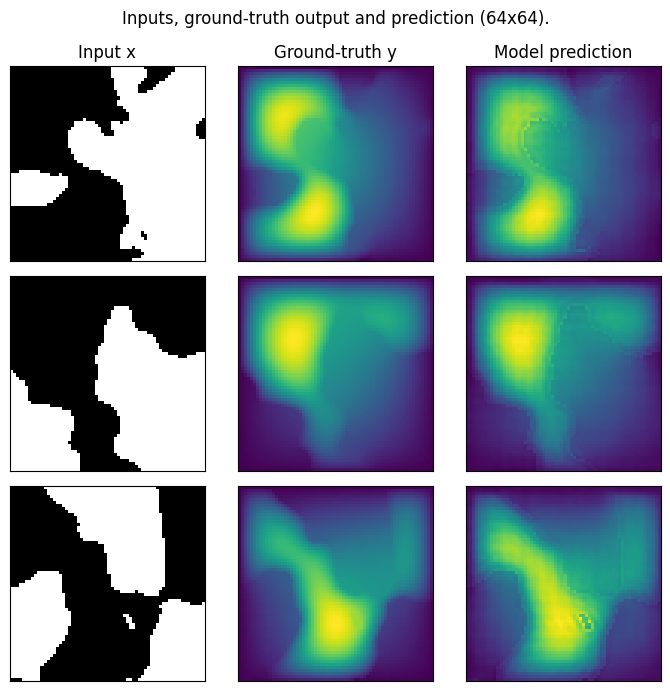

In [19]:
test_samples = test_loaders[64].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (64x64).', y=0.98)
plt.tight_layout()
plt.show()

In [20]:
wandb.finish()

16_h1,█▇▆▅▅▃▄▃▃▂▃▂▂▂▂▁▁▁▁▁
16_l2,▆▆█▄▄▂▃▃▄▂▃▂▂▂▂▁▁▁▁▁
32_h1,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
32_l2,▆▆█▄▄▃▃▃▄▂▃▂▂▂▂▁▁▁▁▁
64_h1,█▆▅▄▄▃▃▃▃▂▃▂▂▂▂▁▁▁▁▁
64_l2,▆▆█▄▄▃▃▃▄▂▃▂▂▂▂▁▁▁▁▁
avg_loss,██▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
lr,████▇▇▇▆▆▆▅▅▄▄▃▃▂▂▁▁
time,█▁▁▃▂▂▂▂▂▁▁▂▁▂▂▂▂▁▁▂
train_err,██▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
16_h1,0.36119
